<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [1]:
!wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw3/requirements.txt

--2023-05-16 15:52:24--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw3/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      77  --.-KB/s    in 0s      

2023-05-16 15:52:24 (4.26 MB/s) - ‘requirements.txt’ saved [77/77]



In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.2/273.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━

In [3]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy

warnings.filterwarnings("ignore")

In [4]:
import logging

logging.disable(level=logging.WARNING)

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [5]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 24.8MB/s]                   


Взглянем на то, что представляют из себя данные:

In [6]:
df.head()

,Date,CashIn,CashOut
4,1/5/2016,20840.0,22200.0
5,1/6/2016,28460.0,18810.0
6,1/7/2016,19250.0,23210.0
7,1/8/2016,49770.0,4350.0
8,1/9/2016,NaN,NaN


В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [7]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime as dt
%matplotlib inline

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [10]:
df.describe()

,CashIn,CashOut,target
count,1081.000000,1094.000000,1072.000000
mean,37261.618871,-30985.648995,5976.651119
std,20583.186636,18314.048275,21551.659802
min,100.000000,-111700.000000,-75190.000000
25%,21690.000000,-40375.000000,-6277.500000
50%,34980.000000,-27895.000000,5320.000000
75%,50280.000000,-18010.000000,18515.000000
max,121300.000000,-0.000000,85160.000000


<Axes: >

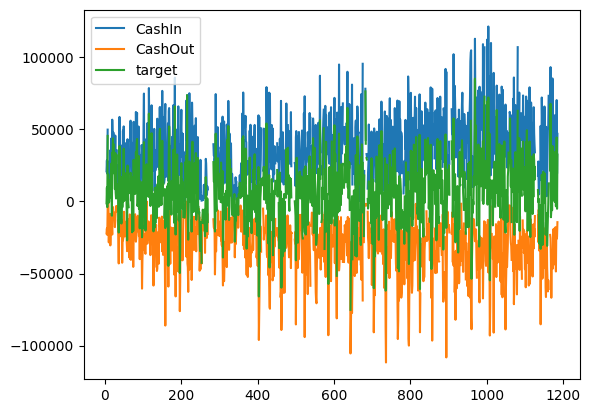

In [11]:
df.plot()

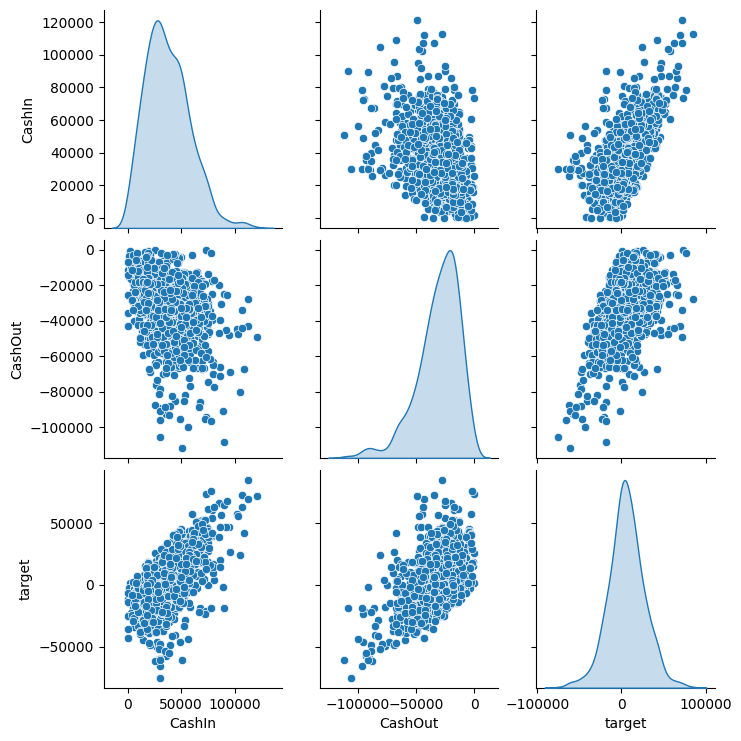

In [12]:
sns.pairplot(df, diag_kind="kde");

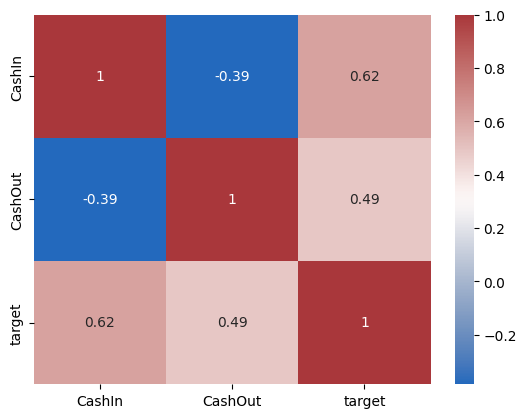

In [13]:
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df.corr("pearson"), annot=True, cmap=cmap);

In [14]:
df.isna().sum()

Date         0
CashIn     101
CashOut     88
target     110
dtype: int64

In [15]:
df_clean = df.dropna()

In [16]:
df_clean.isna().sum()

Date       0
CashIn     0
CashOut    0
target     0
dtype: int64

In [17]:
df_clean['Date'] = pd.to_datetime(df_clean['Date'])


df_clean_2016 = df_clean[df_clean.Date.dt.year == 2016]
df_clean_2018 = df_clean[df_clean.Date.dt.year == 2018]
df_clean_2019 = df_clean[df_clean.Date.dt.year == 2019]

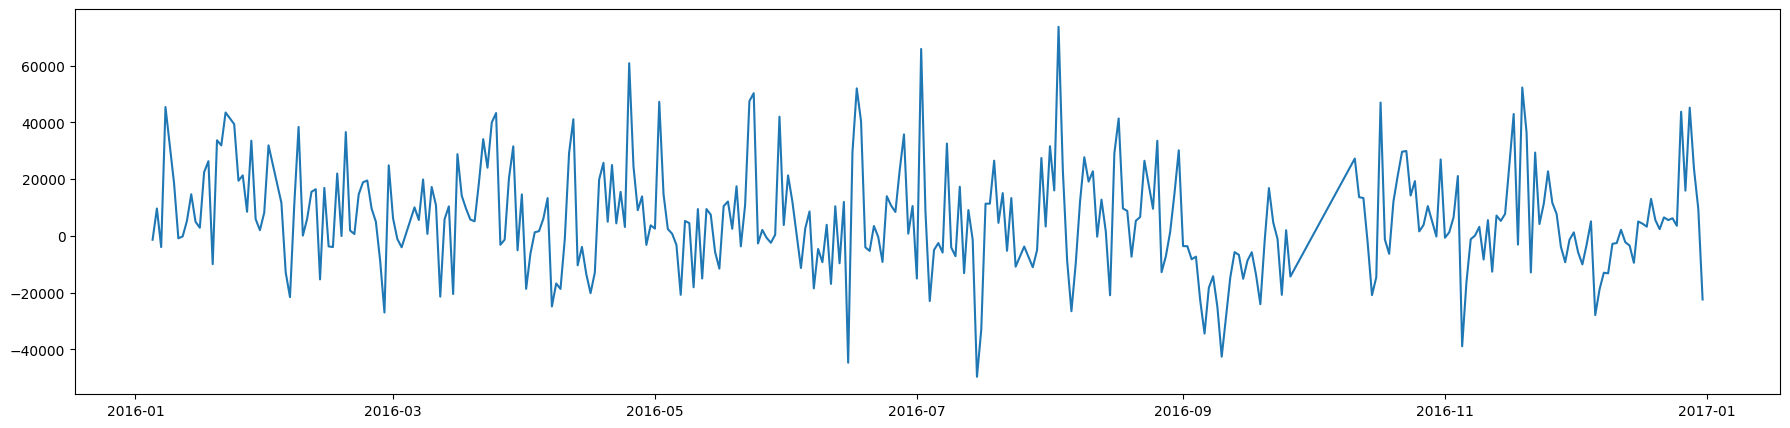

In [18]:
figure(figsize=(22, 5))

plt.plot(df_clean_2016["Date"], df_clean_2016["target"])

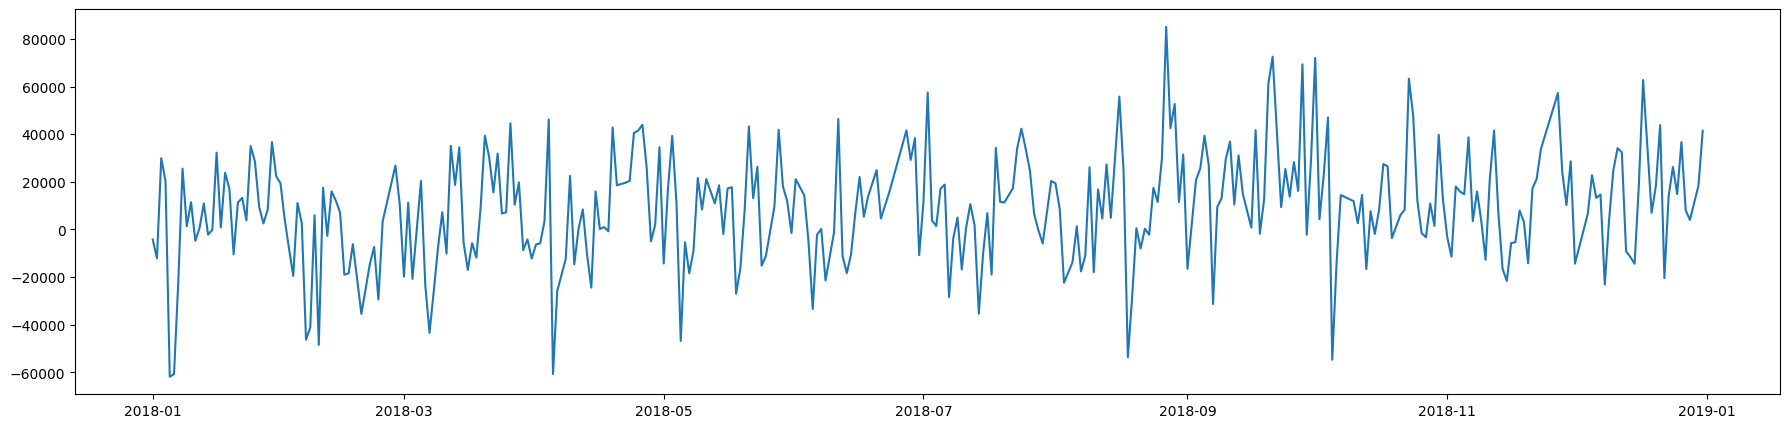

In [19]:
figure(figsize=(22, 5))

plt.plot(df_clean_2018["Date"], df_clean_2018["target"])

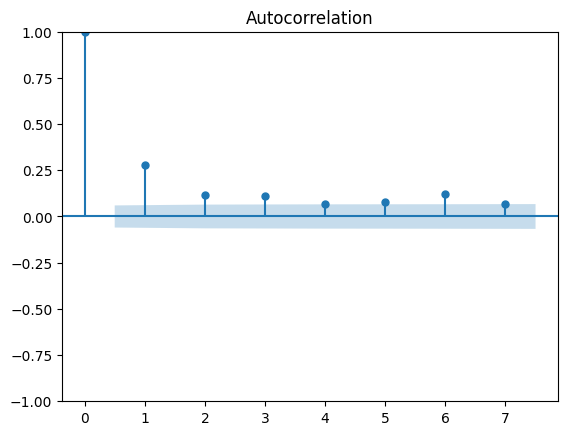

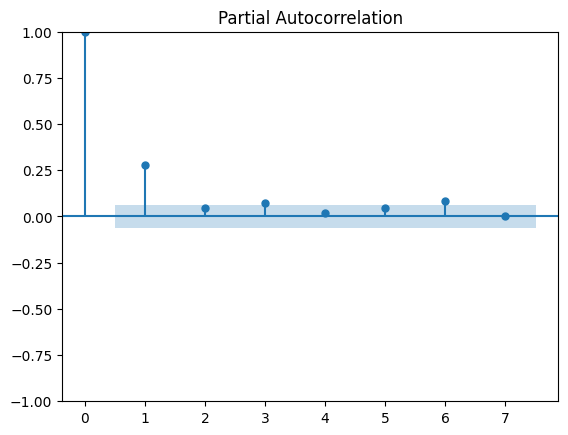

In [20]:
plot_acf(df_clean["target"], lags = 7);
plot_pacf(df_clean["target"], lags = 7);

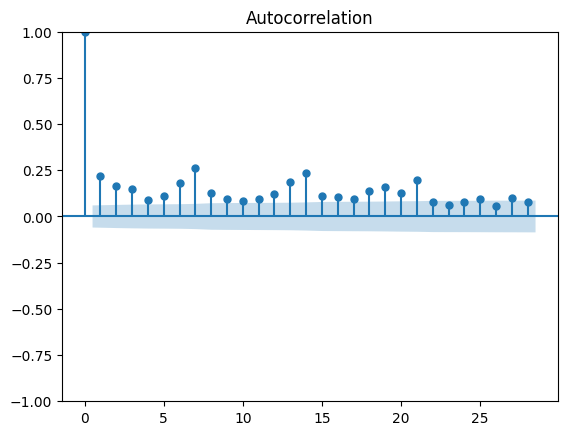

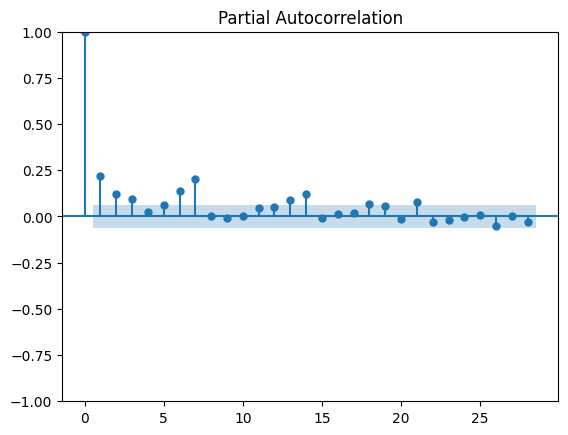

In [21]:
plot_acf(df_clean["CashIn"], lags = 28);
plot_pacf(df_clean["CashIn"], lags = 28);

Тренд - примерно константа около нуля

Сезонность - видно еженедельное пополнение банкоматов (вероятно, через инкассаторов), а также снятие где-то в конце каждого месяца

CashIn и CashOut коррелируют, что логично, ведь банк пытается не допустить большой нехватки или, наоборот, избытка наличности

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [22]:
from etna.datasets import TSDataset

In [23]:
df_ts = df.copy()
df_ts = pd.melt(df_ts, id_vars=["Date"], value_vars = ["CashIn", "CashOut", "target"])
df_ts["timestamp"] = pd.to_datetime(df_ts['Date'])
df_ts.drop(columns=["Date"], inplace=True)

df_ts.columns = ["segment", "target", "timestamp"]

df_tsd = TSDataset.to_dataset(df_ts)
ts = TSDataset(df_tsd, freq="D")

In [24]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182          101
CashOut       2016-01-05    2019-03-31    1182           88
target        2016-01-05    2019-03-31    1182          110


In [25]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
CashIn,2016-01-05,2019-03-31,1182,101,3,0,0,0,D
CashOut,2016-01-05,2019-03-31,1182,88,3,0,0,0,D
target,2016-01-05,2019-03-31,1182,110,3,0,0,0,D


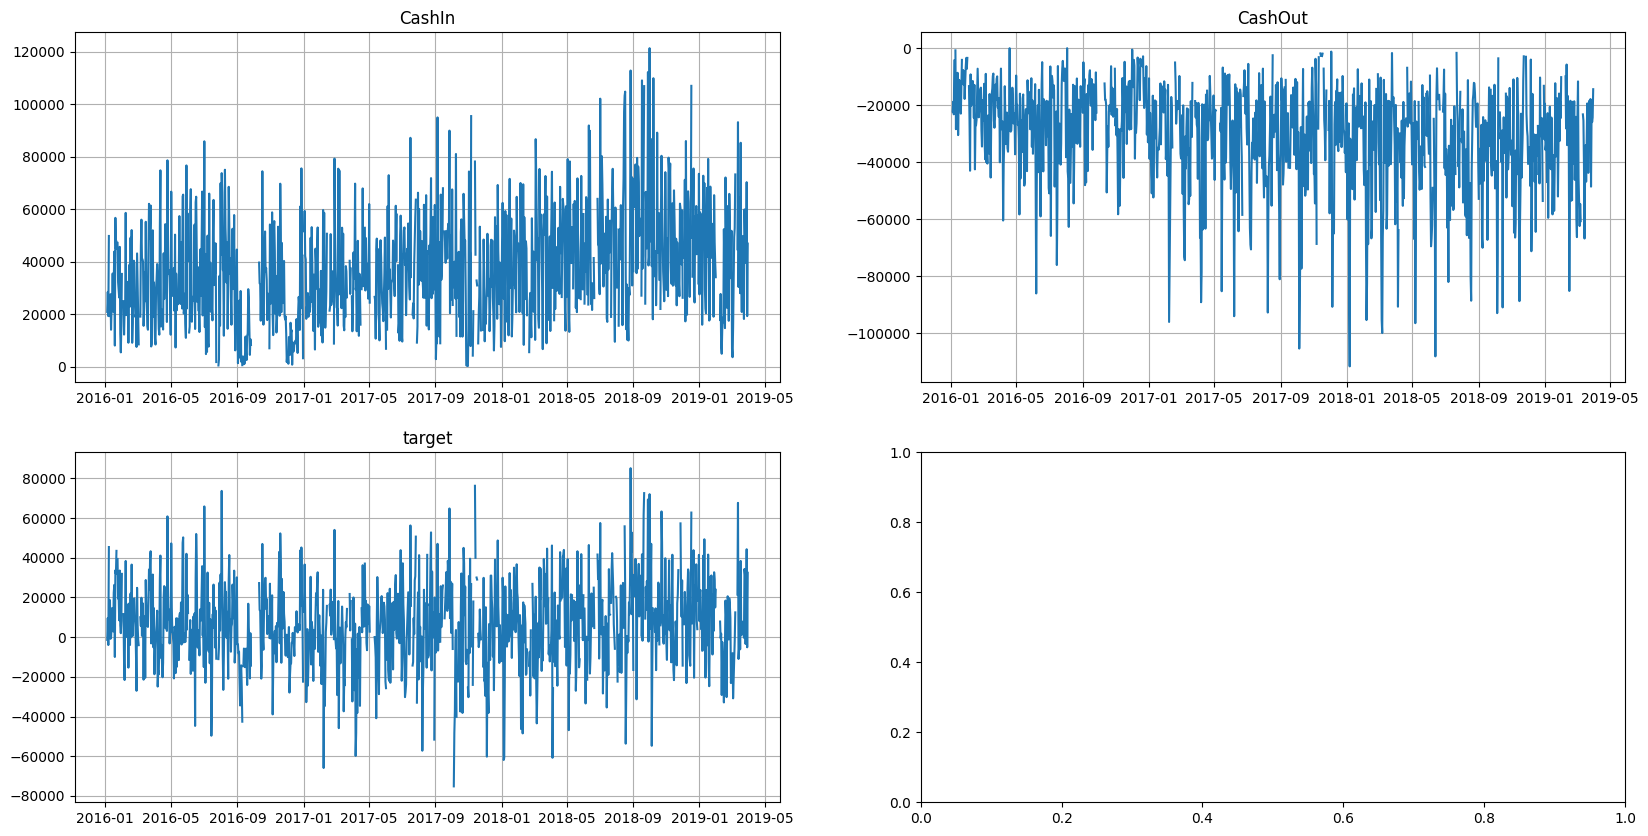

In [26]:
ts.plot()

In [27]:
from etna.analysis import (
    plot_backtest,
    plot_residuals,
    acf_plot,
    get_residuals,
    plot_anomalies,
    stl_plot,
)

In [28]:
from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_anomalies_interactive, plot_backtest,
                           plot_correlation_matrix, plot_forecast,
                           sample_acf_plot, sample_pacf_plot)
from etna.analysis.outliers import (get_anomalies_density, get_anomalies_hist,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)

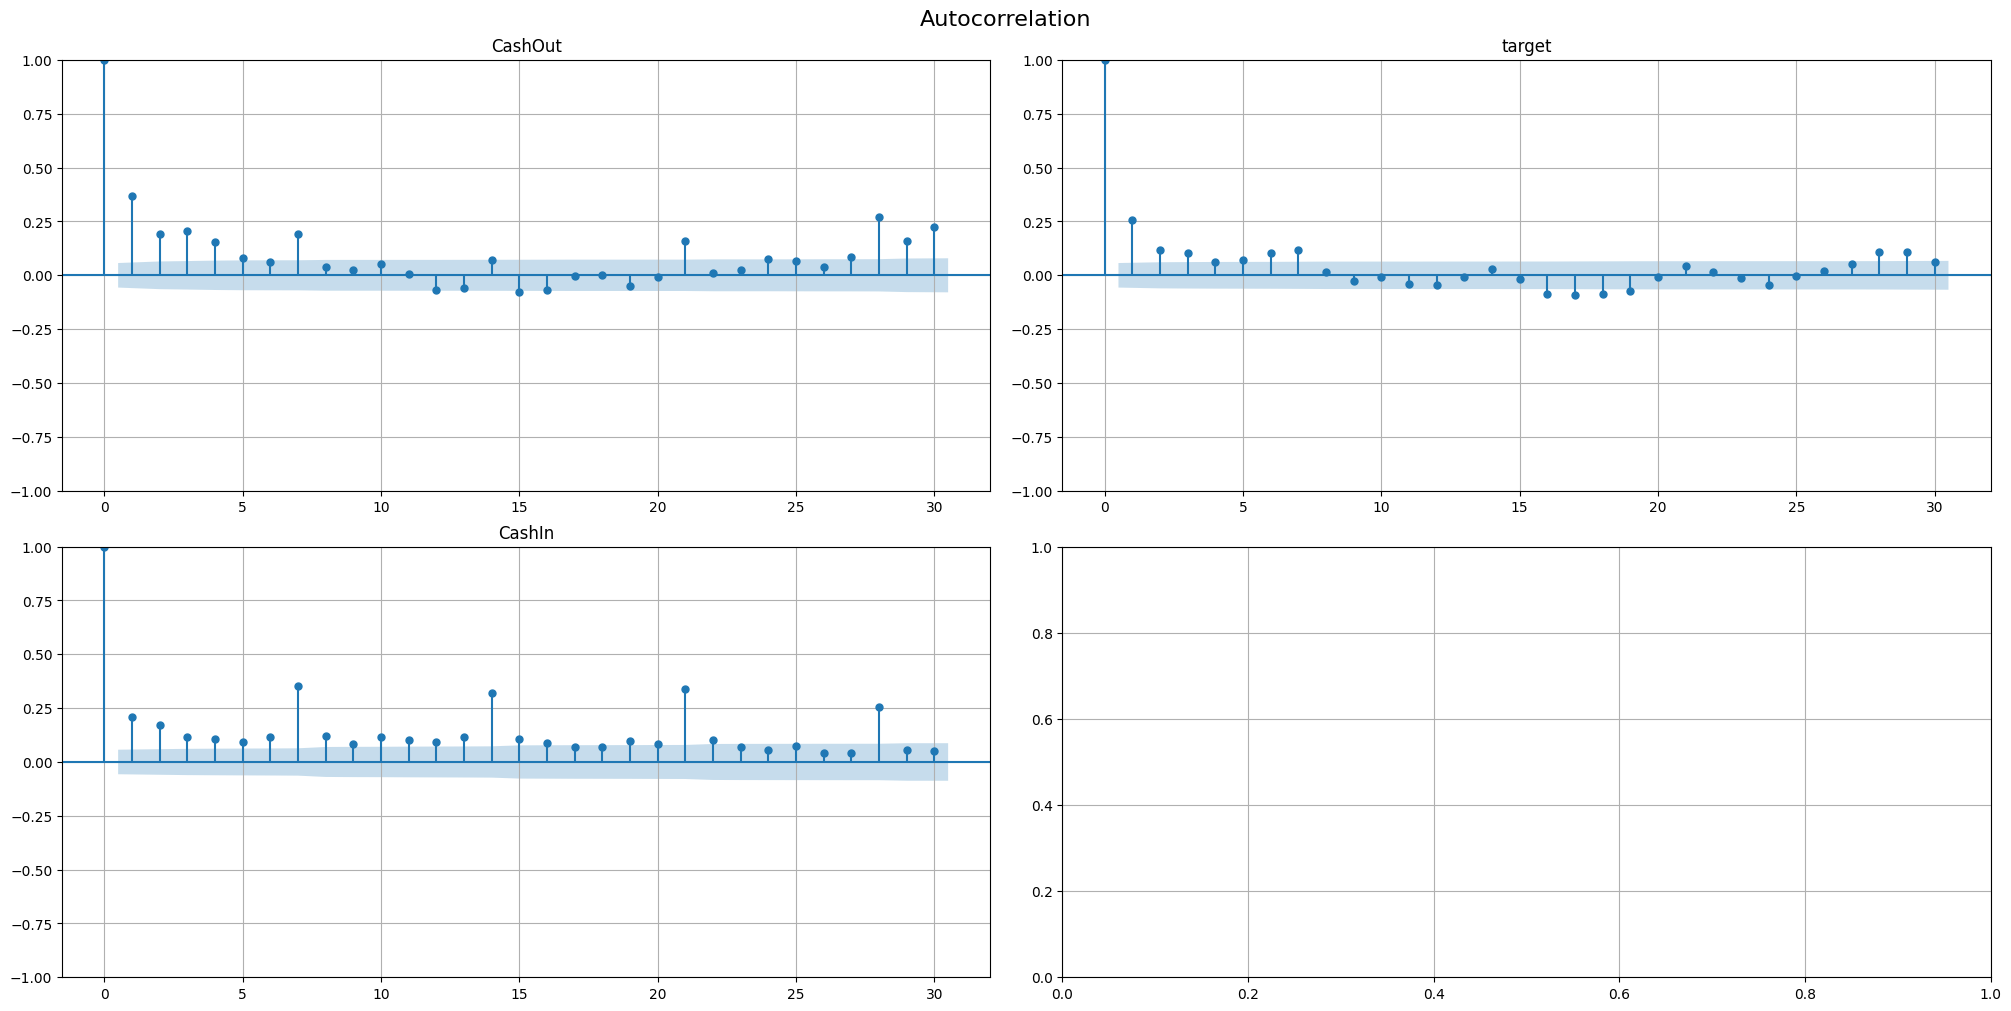

In [29]:
sample_acf_plot(ts, lags=30)

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [30]:
from etna.transforms import TimeSeriesImputerTransform
from etna.analysis import plot_imputation

In [31]:
imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=30
)

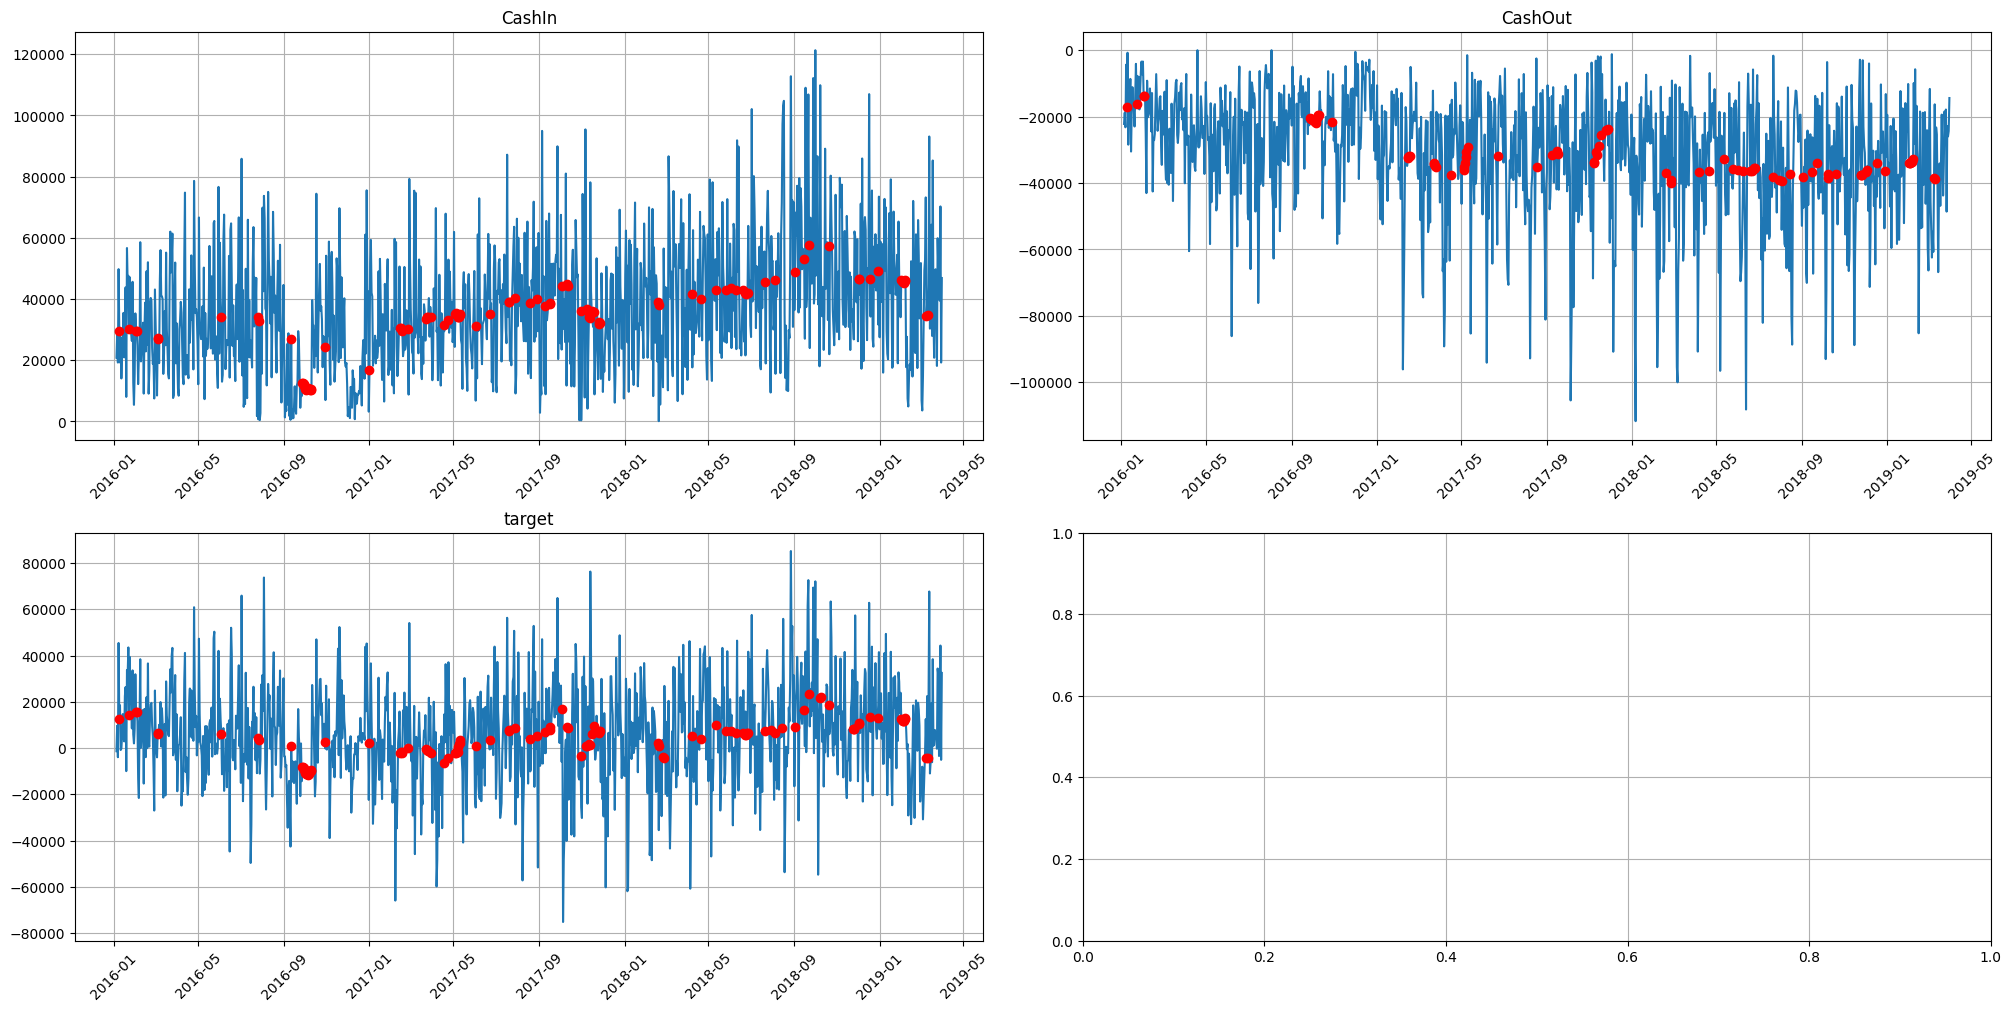

In [32]:
plot_imputation(ts, imputer) 

In [33]:
df_ts_e = df.copy()
df_ts_e = pd.melt(df_ts_e, id_vars=["Date"], value_vars = ["CashIn", "CashOut", "target"])
df_ts_e["timestamp"] = pd.to_datetime(df_ts_e['Date'])
df_ts_e.drop(columns=["Date"], inplace=True)

df_ts_e.columns = ["segment", "target", "timestamp"]

df_tsd_e = TSDataset.to_dataset(df_ts_e)
ts_empty = TSDataset(df_tsd_e, freq="D")

In [34]:
ts.fit_transform([imputer])

In [35]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182            0
CashOut       2016-01-05    2019-03-31    1182            0
target        2016-01-05    2019-03-31    1182            0


In [36]:
ts_empty.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182          101
CashOut       2016-01-05    2019-03-31    1182           88
target        2016-01-05    2019-03-31    1182          110


Заполнять будем просто бегущим средним

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

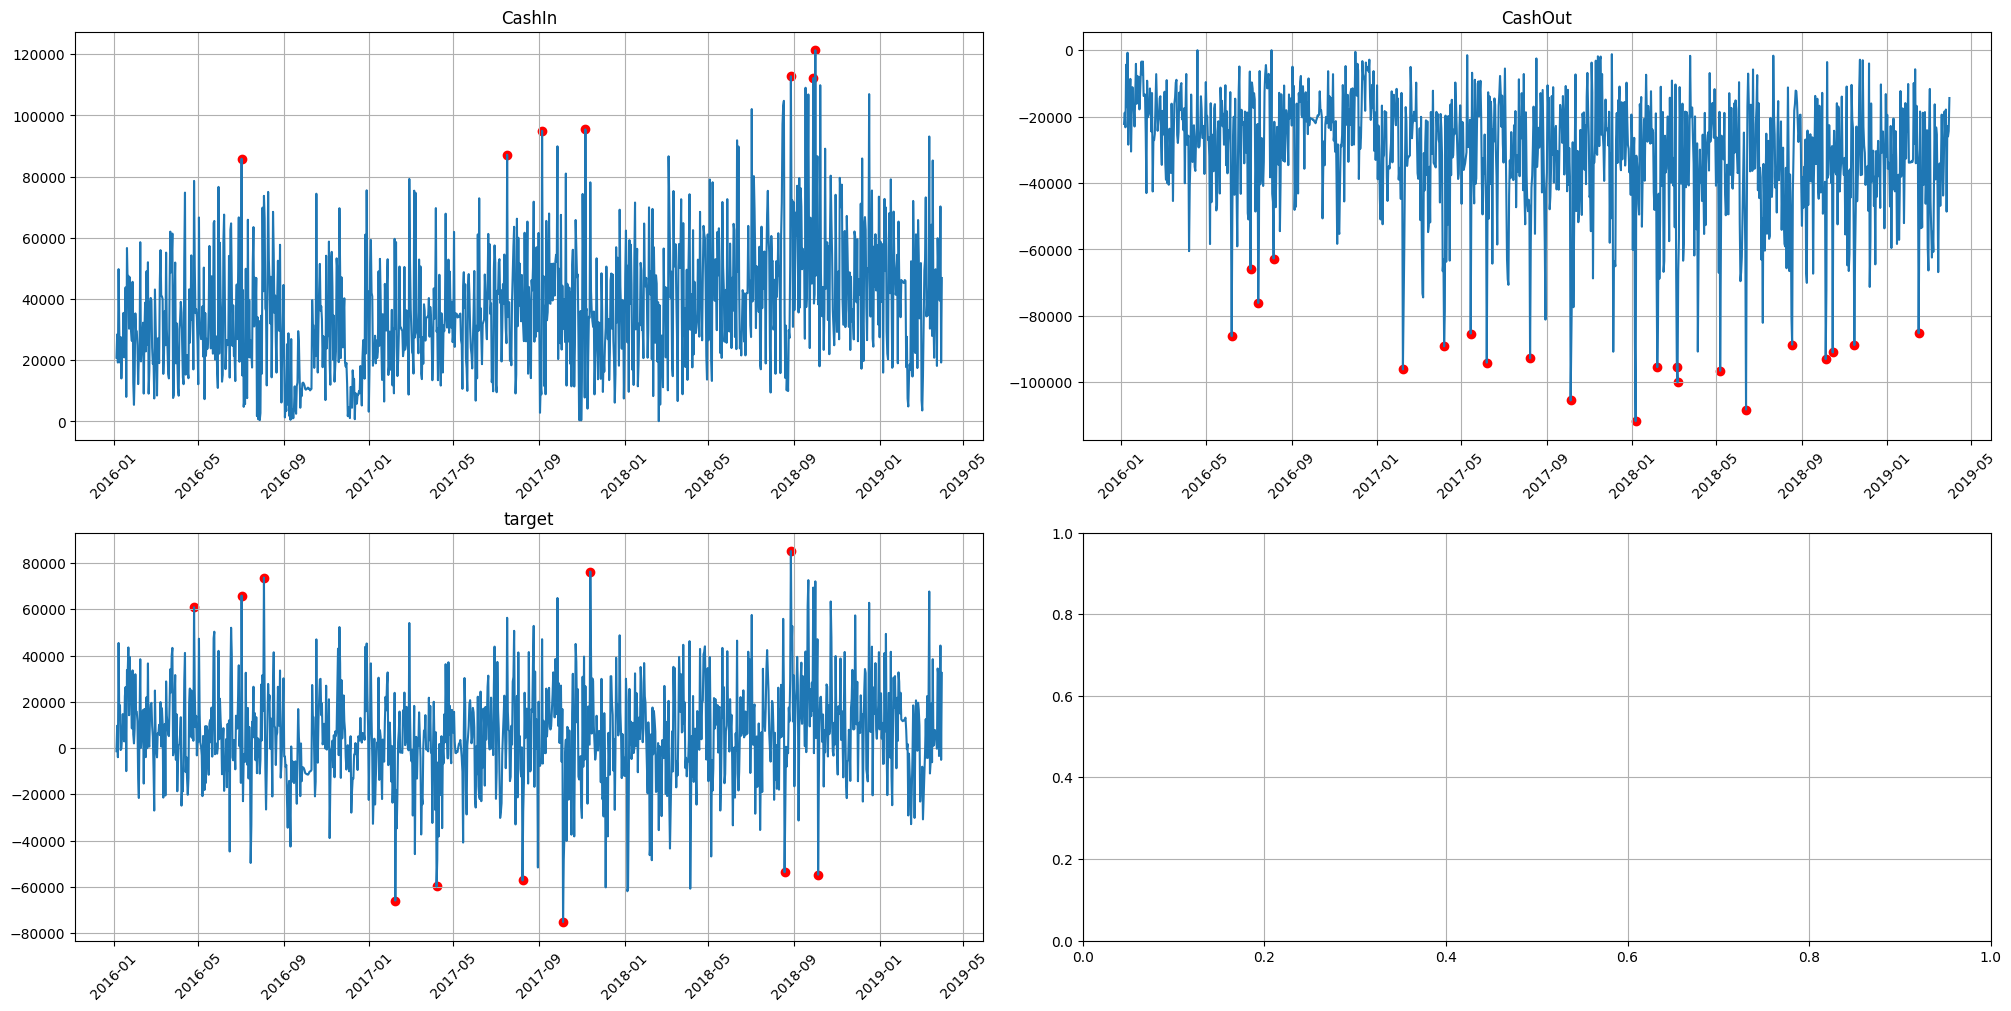

In [37]:
anomaly_dict = get_anomalies_median(ts, window_size=300) 
plot_anomalies(ts, anomaly_dict)

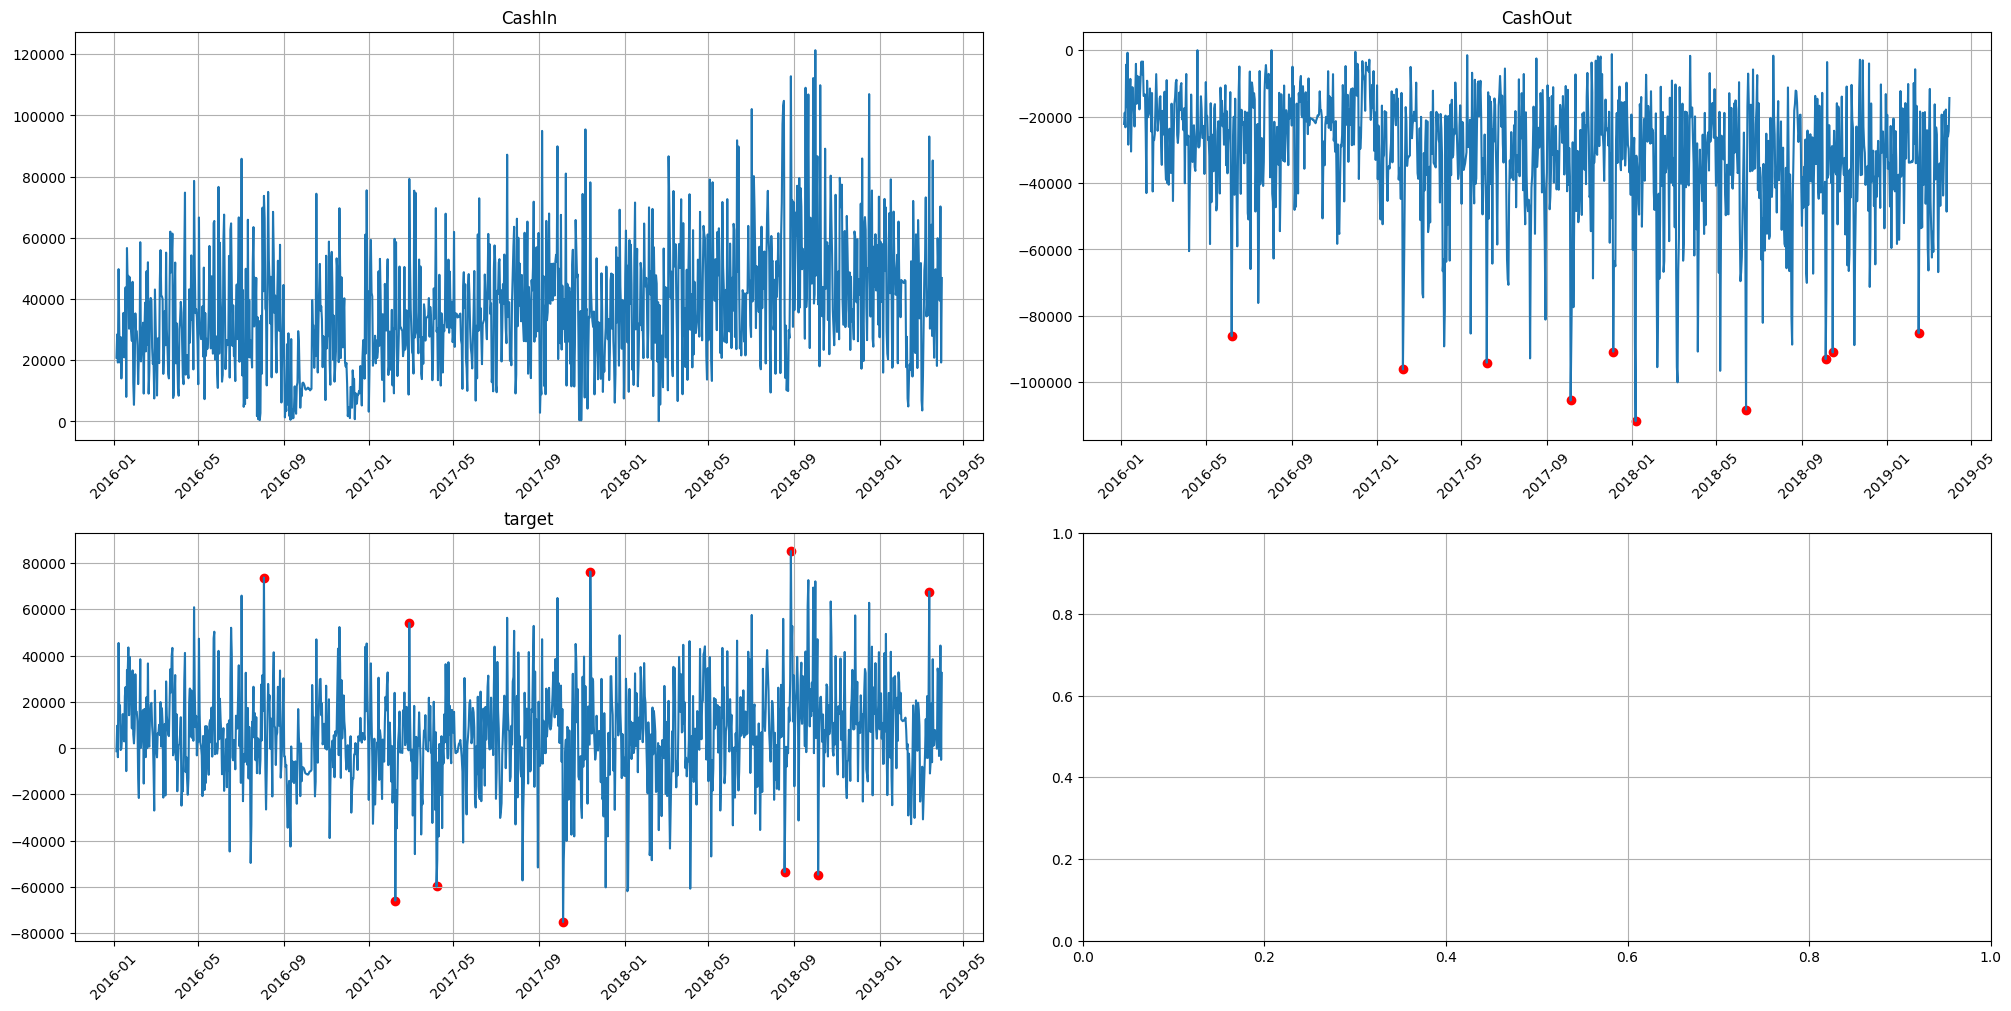

In [38]:
anomaly_dict = get_anomalies_density(ts, window_size=90, distance_coef=1, n_neighbors=4)
plot_anomalies(ts, anomaly_dict)

In [39]:
from etna.transforms import DensityOutliersTransform

In [40]:
outliers_remover = DensityOutliersTransform(in_column="target", window_size=90, distance_coef=1, n_neighbors=4)
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=90
)

ts.fit_transform([outliers_remover, outliers_imputer])

Будем использовать Density-based approach, так как он является самым гибким и легко настраиваемым. В случае остальнных детектеров, они отмечают слишком много точек даже при подборе параметров, что мне не нравится (можем потерять какую-то важную информацию)

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [41]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [42]:
HORIZON = 5

In [43]:
model = ProphetModel() 
transforms = []  
prophet_pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)  

metrics_df, forecast_df, fold_info_df = prophet_pipeline.backtest(
    ts=ts, metrics=[SMAPE()], aggregate_metrics=True
)

metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.2s finished


,segment,SMAPE
0,CashIn,32.760484
1,CashOut,35.635125
2,target,131.244267


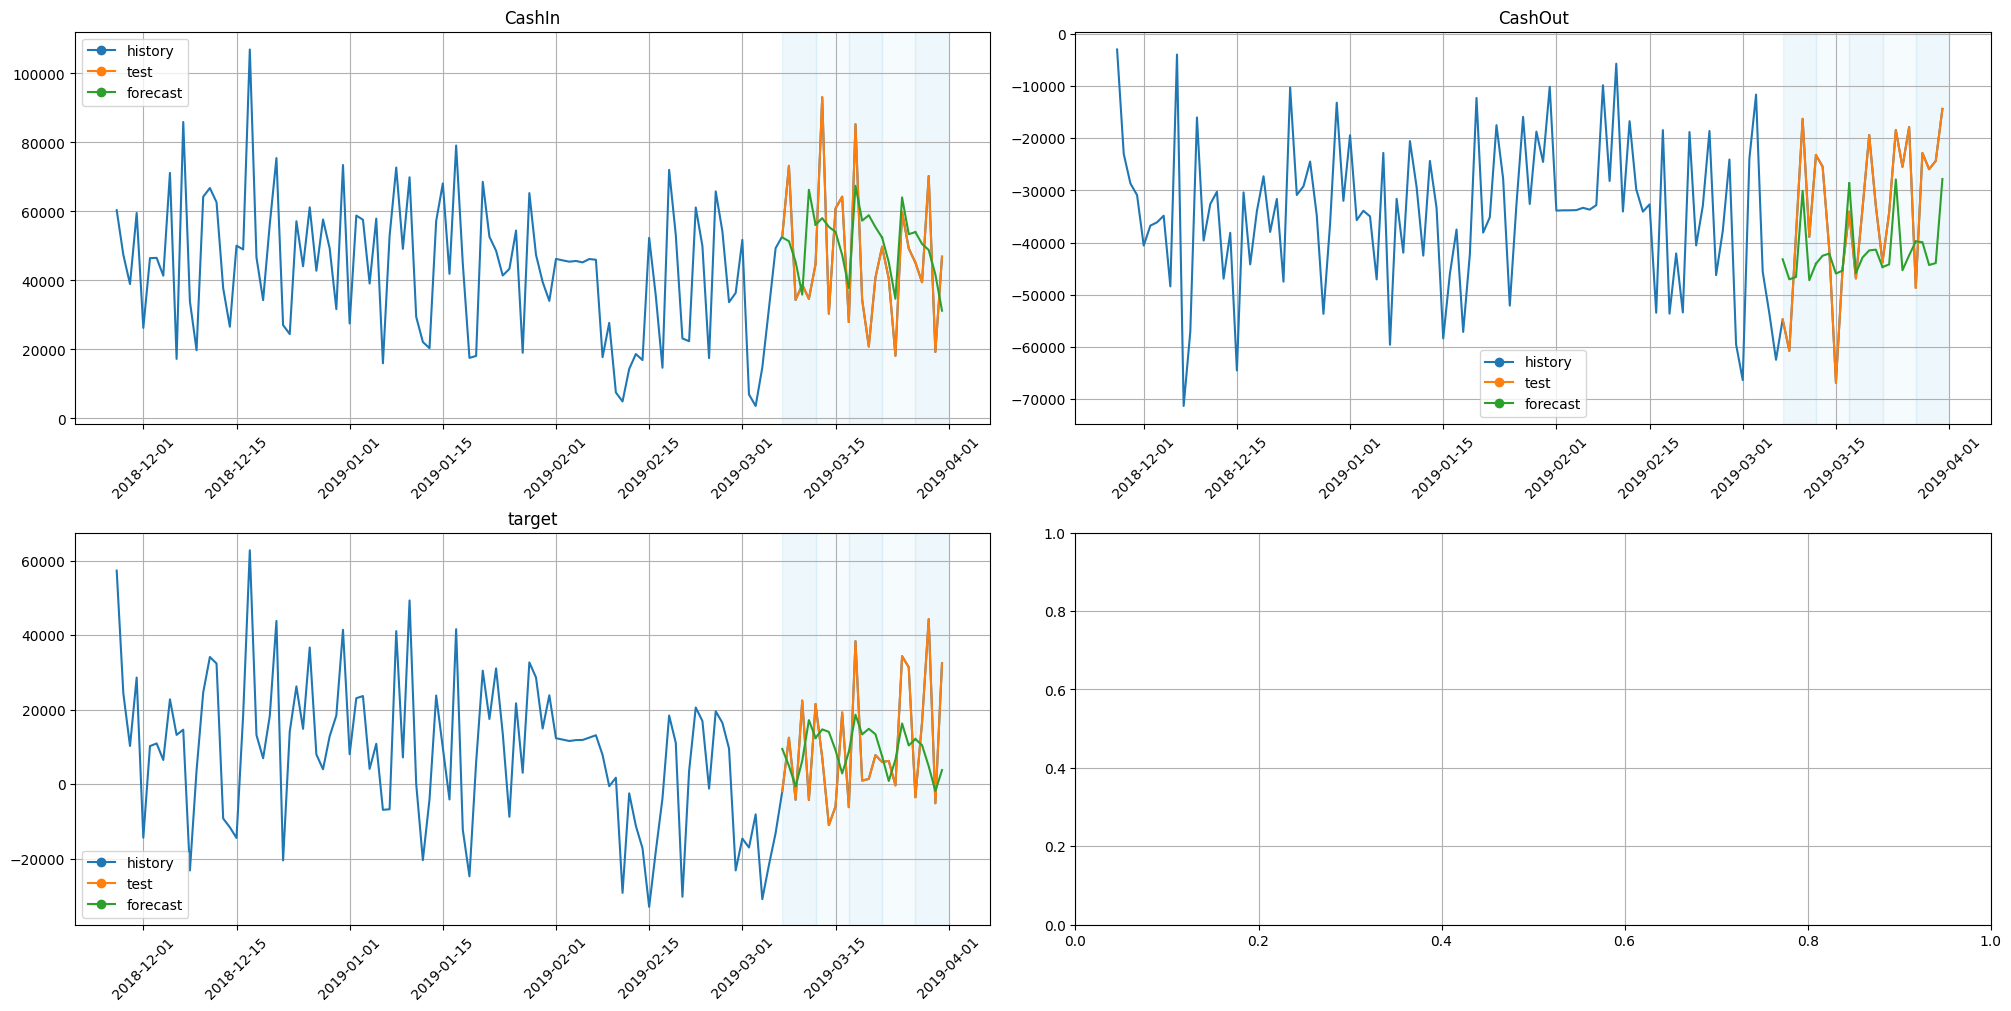

In [44]:
plot_backtest(forecast_df, ts, history_len=100)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

Может показаться, что лучше предсказывать сначала отдельно CashIn и CashOut, а потом их складывать, но это просто особенность метрики SMAPE. Однозначно сказать нельзя, и это уже видно по MAE

In [45]:
metrics_df, forecast_df, fold_info_df = prophet_pipeline.backtest(
    ts=ts, metrics=[MAE()], aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.0s finished


In [46]:
metrics_df

,segment,MAE
0,CashIn,15130.850142
1,CashOut,12138.645306
2,target,13803.844158


### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [47]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [48]:
df_h = df.copy()
df_h = pd.melt(df_h, id_vars=["Date"], value_vars = ["CashIn", "CashOut"])
df_h["timestamp"] = pd.to_datetime(df_h['Date'])
df_h.drop(columns=["Date"], inplace=True)

df_h.columns = ["segment", "target", "timestamp"]

hierarchical_df = TSDataset.to_dataset(df=df_h)

In [49]:
hierarchical_structure = HierarchicalStructure(
    level_structure={"sum": ["CashIn", "CashOut"]}, level_names=["sum", "in_out"]
)

hierarchical_ts = TSDataset(df=hierarchical_df, freq="D", hierarchical_structure=hierarchical_structure)

hierarchical_ts.head()

segment,CashIn,CashOut
feature,target,target
timestamp,,
2016-01-05,20840.0,-22200.0
2016-01-06,28460.0,-18810.0
2016-01-07,19250.0,-23210.0
2016-01-08,49770.0,-4350.0
2016-01-09,NaN,NaN


In [50]:
hierarchical_ts.current_df_level

'in_out'

In [51]:
reconciliator = BottomUpReconciliator(target_level="sum", source_level="in_out")

In [52]:
hierarchical_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 2
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182          101
CashOut       2016-01-05    2019-03-31    1182           88


Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [53]:
outliers_remover = DensityOutliersTransform(in_column="target", window_size=90, distance_coef=1, n_neighbors=4)
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=90
)

hierarchical_ts.fit_transform([outliers_remover, outliers_imputer])

In [54]:
hierarchical_pipeline = HierarchicalPipeline(
    transforms=[],
    model=ProphetModel(),
    reconciliator=BottomUpReconciliator(target_level="sum", source_level="in_out"),
)

bottom_up_metrics, _, _ = hierarchical_pipeline.backtest(ts=hierarchical_ts, metrics=[MAE(), SMAPE()], aggregate_metrics=True)

bottom_up_metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.9s finished


,segment,MAE,SMAPE
0,sum,19287.031533,133.176359


### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [55]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel, LinearPerSegmentModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform, LinearTrendTransform

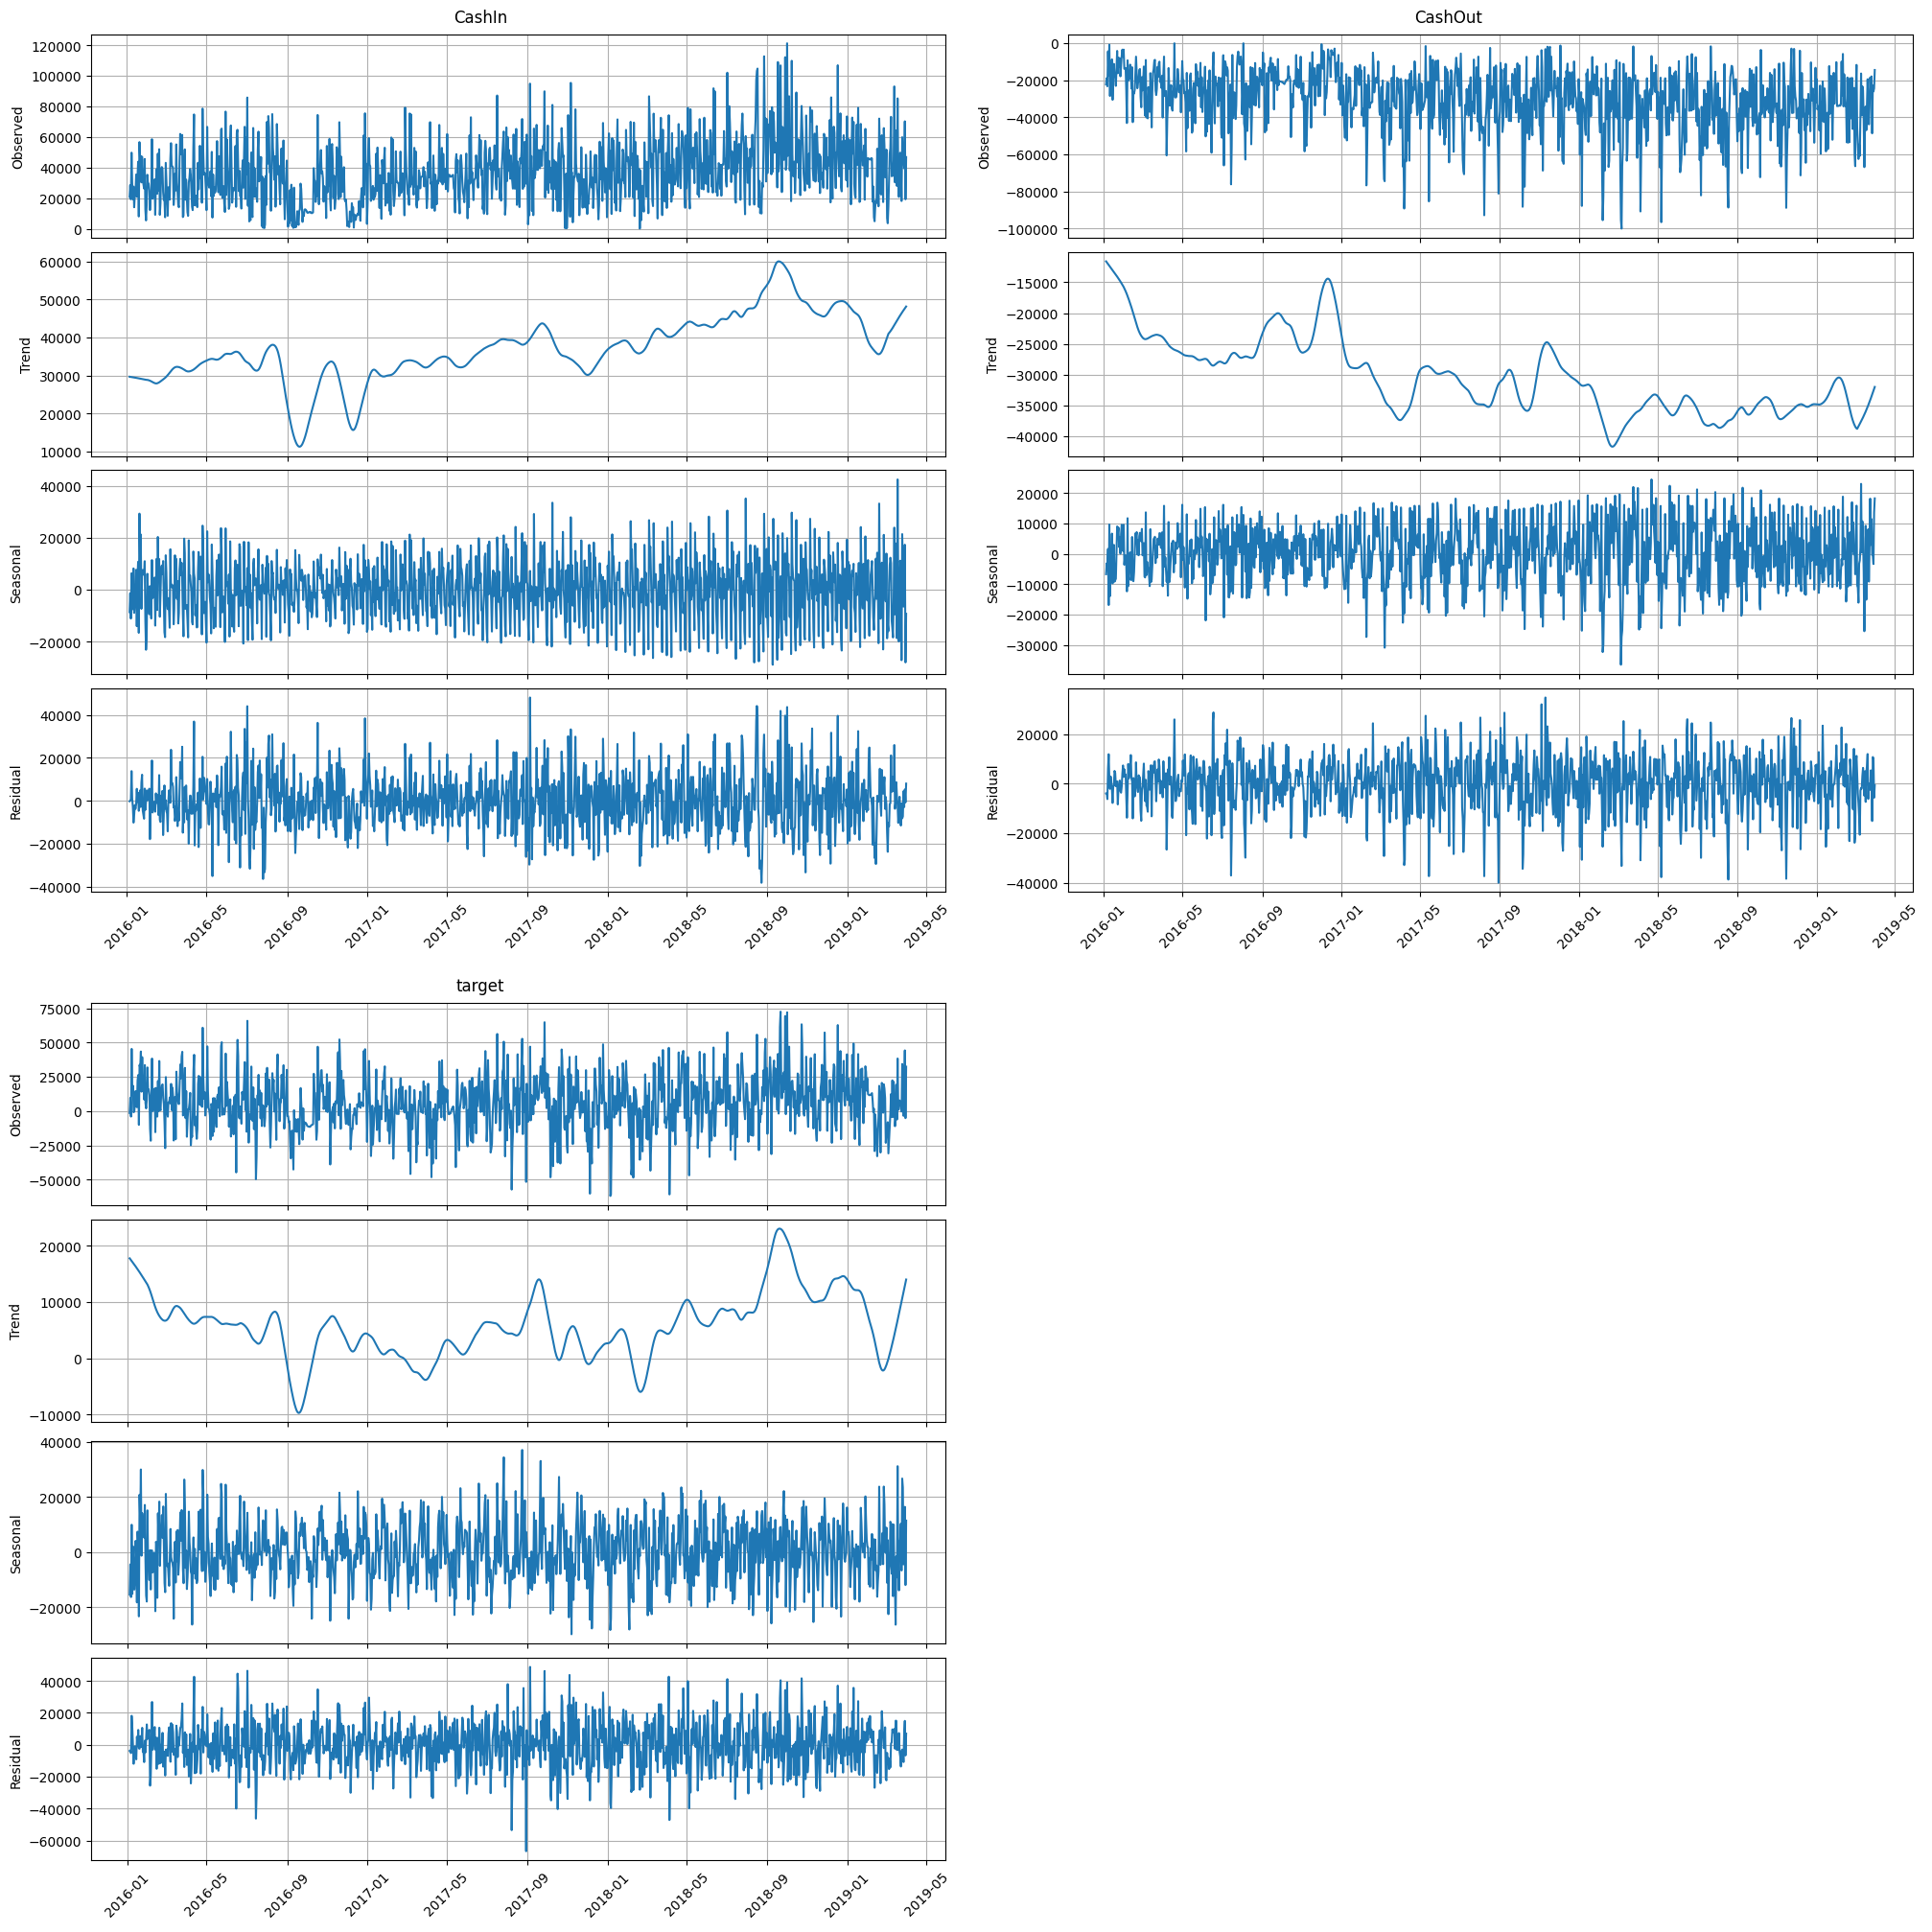

In [56]:
stl_plot(ts, period=28)

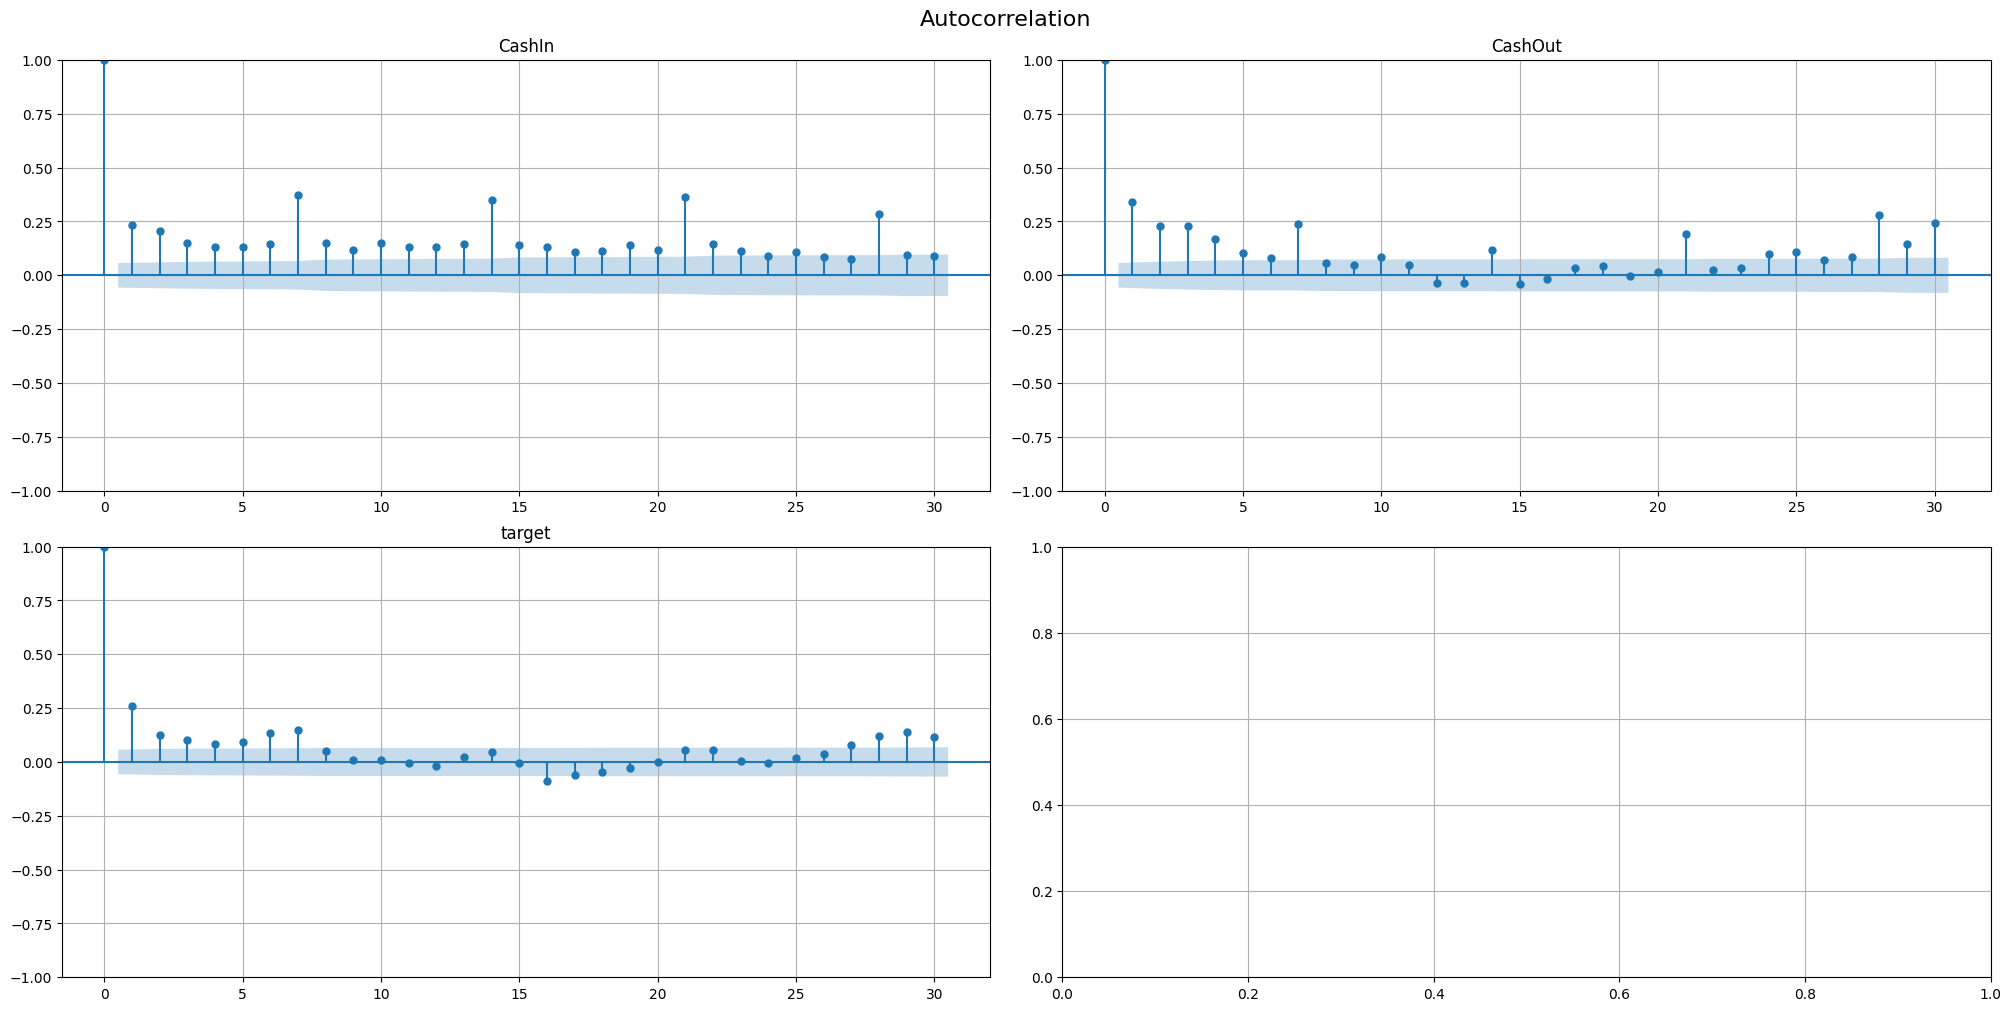

In [57]:
sample_acf_plot(ts, lags=30)

Как я уже писал ранеее, хорошо видна недельная сезонность в CashIn (возможно, связанная с инкассаторами) и месячная в CashOut. После проверки различных лагов оставил только 7, так как дает лучший результат.

In [58]:
catboost_multi_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[LinearTrendTransform(in_column="target"), LagTransform(lags=[7], in_column="target"), STLTransform(in_column="target", period=7, model="arima"), SegmentEncoderTransform()
],
    horizon=HORIZON,
)

metrics, forecast, _ = catboost_multi_pipeline.backtest(
            ts=ts,
            metrics=[MAE(), SMAPE()],
            aggregate_metrics=True,
        )


metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.5s finished


,segment,MAE,SMAPE
0,CashIn,19341.492634,43.334588
1,CashOut,13299.254759,39.950035
2,target,16566.373776,127.714219


In [59]:
catboost_segment_pipeline = Pipeline(
    model=CatBoostModelPerSegment(),
    transforms=[LinearTrendTransform(in_column="target"), LagTransform(lags=[7], in_column="target"), STLTransform(in_column="target", period=7, model="arima"), SegmentEncoderTransform()
],
    horizon=HORIZON,
)

metrics, forecast, _ = catboost_segment_pipeline.backtest(
            ts=ts,
            metrics=[MAE(), SMAPE()],
            aggregate_metrics=True,
        )


metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.2s finished


,segment,MAE,SMAPE
0,CashIn,20861.312508,46.237793
1,CashOut,12226.536334,37.096474
2,target,14266.830473,119.626224


In [60]:
arima_pipeline = Pipeline(
    model=AutoARIMAModel(),
    transforms=[
],
    horizon=HORIZON,
)

metrics, forecast, _ = arima_pipeline.backtest(
            ts=ts,
            metrics=[MAE(), SMAPE()],
            aggregate_metrics=True,
        )


metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 11.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 15.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 15.3min finished


,segment,MAE,SMAPE
0,CashIn,14049.365333,31.196340
1,CashOut,11029.898716,33.362769
2,target,12916.493665,131.303792


### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [61]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [62]:
catboost_segment_pipeline = Pipeline(
    model=CatBoostModelPerSegment(),
    transforms=[LinearTrendTransform(in_column="target"), LagTransform(lags=[7], in_column="target"), STLTransform(in_column="target", period=7, model="arima"), SegmentEncoderTransform()
],
    horizon=HORIZON,
)

metrics, forecast, _ = catboost_segment_pipeline.backtest(
            ts=ts,
            metrics=[MAE(), SMAPE()],
            aggregate_metrics=True,
        )


metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.9s finished


,segment,MAE,SMAPE
0,CashIn,20861.312508,46.237793
1,CashOut,12226.536334,37.096474
2,target,14266.830473,119.626224


In [63]:
autoregressive_pipeline = AutoRegressivePipeline(
    model=CatBoostModelPerSegment(),
    transforms=[LagTransform(lags=list(range(1, 8)), in_column="target"), STLTransform(in_column="target", period=7, model="arima"), SegmentEncoderTransform()
],
    horizon=HORIZON,
)

metrics, forecast, _ = autoregressive_pipeline.backtest(
            ts=ts,
            metrics=[MAE(), SMAPE()],
            aggregate_metrics=True,
        )


metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   37.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.3s finished


,segment,MAE,SMAPE
0,CashIn,19054.860479,43.267081
1,CashOut,11291.211431,35.253409
2,target,17235.237877,133.130522


In [64]:
models = [CatBoostModelPerSegment(), CatBoostMultiSegmentModel()]
transforms = [LagTransform(in_column="target", lags=[7]), STLTransform(in_column="target", period=7, model="arima"), SegmentEncoderTransform()
]

pipelines = assemble_pipelines(models=models, transforms=transforms, horizons=[7, 14])

In [65]:
ensemble = DirectEnsemble(pipelines=pipelines)

metrics_ensemble_df_2, forecast_ensemble_df_2, _ = ensemble.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], aggregate_metrics=True
)

metrics_ensemble_df_2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    

,segment,MAE,SMAPE
0,CashIn,26156.436788,58.513658
1,CashOut,13839.804705,45.407851
2,target,21911.560427,137.330465


Обычный Pipeline дает лучший результат)

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [66]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [67]:
pipelines = [catboost_segment_pipeline, catboost_multi_pipeline, autoregressive_pipeline, prophet_pipeline]

In [68]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[10, 3, 3, 2])

voting_ensamble_metrics, _, _ = voting_ensemble.backtest(
    ts=ts,
    metrics=[MAE(), SMAPE()],
    aggregate_metrics=True
)

voting_ensamble_metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | ela

,segment,MAE,SMAPE
0,CashIn,19214.841305,42.250462
1,CashOut,11675.553563,35.863780
2,target,14452.584172,121.207960


In [69]:
pipelines = [catboost_segment_pipeline, catboost_multi_pipeline, autoregressive_pipeline, prophet_pipeline]

In [70]:
stacking_ensemble_unfeatured = StackingEnsemble(
    pipelines=pipelines
)

Не получилось в него засунуть просто ts, так как ругался на "target". В итоге переименовал "target" в "main" и оставил только его

In [71]:
df_t = df.copy()
df_t = pd.melt(df_t, id_vars=["Date"], value_vars = ["target"])
df_t["timestamp"] = pd.to_datetime(df_t['Date'])
df_t.drop(columns=["Date"], inplace=True)

df_t.columns = ["segment", "target", "timestamp"]

df_t["segment"].replace({"target": "main"}, inplace=True)

df_td = TSDataset.to_dataset(df_t)
ts = TSDataset(df_td, freq="D")

In [72]:
outliers_remover = DensityOutliersTransform(in_column="target", window_size=90, distance_coef=1, n_neighbors=4)
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=90
)

ts.fit_transform([outliers_remover, outliers_imputer])

In [73]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2016-01-05    2019-03-31    1182            0


In [74]:
stacking_ensamble_metrics, _, _ = stacking_ensemble_unfeatured.backtest(
    ts=ts,
    metrics=[MAE(), SMAPE()],
    aggregate_metrics=True,
)
stacking_ensamble_metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | el

,segment,MAE,SMAPE
0,main,14530.010765,127.782305


### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#